<a href="https://colab.research.google.com/github/shruti63-code/Sentiment-Analysis/blob/main/Sentiment_Analysis_Tweets_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Tweets — Deep Learning (LSTM)

This Colab notebook guides you step-by-step to build a **binary sentiment classifier** (positive/negative) for tweets using a **deep learning** model (Embedding + LSTM).

---

## 1) Check environment & GPU (optional)

This cell confirms TensorFlow and checks for GPU availability.

In [1]:

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)


TensorFlow version: 2.19.0
GPUs found: []


## 2) Upload dataset

Upload the `tweet_sentiment_dataset.csv` file.


In [2]:

from google.colab import files
import pandas as pd

print("Choose the CSV file to upload (e.g. tweet_sentiment_dataset.csv)")
uploaded = files.upload()  # Use the upload dialog
# After upload, the filename will be available in uploaded.keys()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print("Loaded:", filename)
df.head()


Choose the CSV file to upload (e.g. tweet_sentiment_dataset.csv)


Saving tweet_sentiment_dataset.csv to tweet_sentiment_dataset.csv
Loaded: tweet_sentiment_dataset.csv


,tweet,sentiment
0,"I love this phone, it's amazing!",1
1,"Worst experience ever, totally disappointed.",0
2,"This new update is fantastic, works smoothly.",1
3,"I hate waiting in long lines, so frustrating!",0
4,The food was delicious and service was excellent.,1


## 3) Quick EDA (exploratory data analysis)

Understand dataset size, class balance and sample tweets.

In [3]:

# Quick checks
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nClass distribution:\n", df['sentiment'].value_counts(normalize=True))
print("\nSample data:")
df.sample(5)


Shape: (10, 2)

Columns: ['tweet', 'sentiment']

Class distribution:
 sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64

Sample data:


,tweet,sentiment
0,"I love this phone, it's amazing!",1
3,"I hate waiting in long lines, so frustrating!",0
7,"This app keeps crashing, very annoying.",0
2,"This new update is fantastic, works smoothly.",1
8,"Great performance by the team, well done!",1


## 4) Text preprocessing — why and how

Tweets contain URLs, mentions, punctuation, emoji, and stopwords. We'll:
- Lowercase text
- Remove URLs, mentions (@username), hashtags (#tag)
- Remove non-alphabetic characters
- Remove stopwords
- (Optional) Lemmatize words to their base form

This helps the model learn signal instead of noise.

In [5]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab') # Add this line to download the missing resource
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # remove URLs
    text = re.sub(r'@\w+', '', text)                       # remove mentions
    text = re.sub(r'#', '', text)                           # remove hash symbol (keep text)
    text = re.sub(r'[^a-z\s]', ' ', text)                  # keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()               # remove extra whitespace
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply cleaning (may take a few seconds)
df['clean_tweet'] = df['tweet'].apply(clean_text)
df[['tweet','clean_tweet']].head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,tweet,clean_tweet
0,"I love this phone, it's amazing!",love phone amazing
1,"Worst experience ever, totally disappointed.",worst experience ever totally disappointed
2,"This new update is fantastic, works smoothly.",new update fantastic work smoothly
3,"I hate waiting in long lines, so frustrating!",hate waiting long line frustrating
4,The food was delicious and service was excellent.,food delicious service excellent
5,"Terrible product, waste of money.",terrible product waste money
6,I am so happy with my results today!,happy result today
7,"This app keeps crashing, very annoying.",app keep crashing annoying
8,"Great performance by the team, well done!",great performance team well done
9,"I regret buying this, not worth it.",regret buying worth


## 5) Prepare data for modeling: Tokenization & Padding

We convert text to integer sequences using Keras Tokenizer and pad them to equal length.

- `num_words`: vocabulary size (top most frequent words)
- `maxlen`: length of sequence (truncate/pad to this length)

In [6]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Parameters (you can tune these)
num_words = 5000    # size of vocabulary
maxlen = 50         # max words per tweet

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_tweet'].values)

sequences = tokenizer.texts_to_sequences(df['clean_tweet'].values)
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

y = df['sentiment'].astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (10, 50)
y shape: (10,)


## 6) Train-test split

Split data into training and testing sets. Use `stratify=y` to keep class proportions.

In [7]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (8, 50) Test shape: (2, 50)


## 7) Build the LSTM model (Keras)

We use an Embedding layer (learned embedding) followed by a Bidirectional LSTM for better context capture.
Architecture:
- Embedding -> Bidirectional(LSTM) -> Dense -> Output(sigmoid)

Adjust `embedding_dim` and LSTM units based on dataset size and GPU availability.

In [8]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

embedding_dim = 100
lstm_units = 128

model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(lstm_units, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 8) Train the model



In [9]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6250 - loss: 0.6883 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.3750 - loss: 0.6984 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3750 - loss: 0.6990 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5000 - loss: 0.6979 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5000 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6250 - loss: 0.6895 - val_accuracy: 0.5000 - val_loss: 0.6899
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7500 - loss: 0.6846 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7500 - loss: 0.6810 - val_accuracy: 0.5000 - val_loss: 0.

## 9) Evaluate model & show metrics


In [10]:

# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

# Predictions and classification report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Test Loss: 0.6896 | Test Accuracy: 0.5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step

Classification report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.5000    1.0000    0.6667         1

    accuracy                         0.5000         2
   macro avg     0.2500    0.5000    0.3333         2
weighted avg     0.2500    0.5000    0.3333         2


Confusion matrix:
 [[0 1]
 [0 1]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 10) Plot training history

Plot training/validation loss and accuracy to inspect overfitting/underfitting.

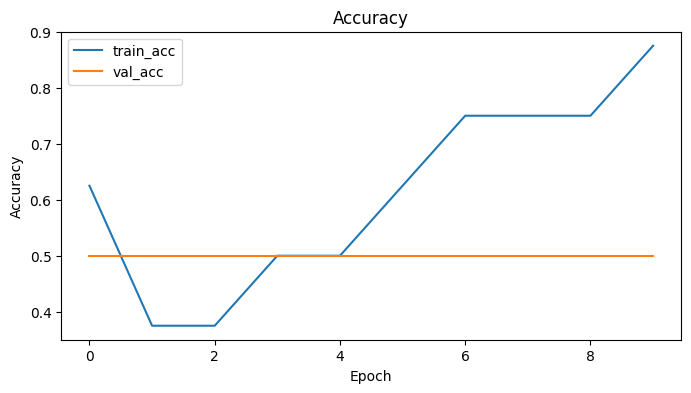

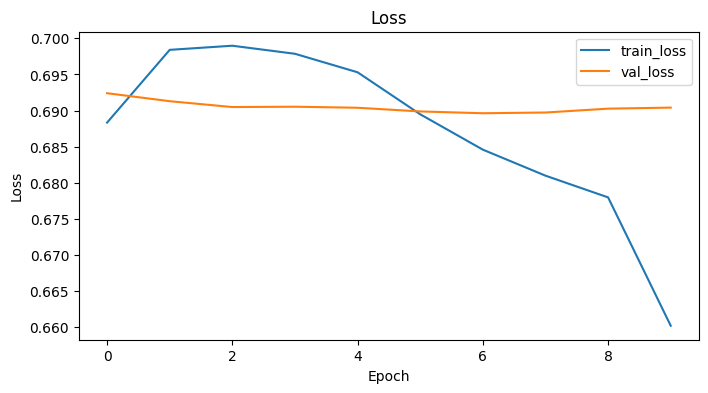

In [11]:

import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 11) Use the model to predict new tweets

Helper function `predict_sentiment` cleans, tokenizes, pads and runs the model on new raw text.

In [12]:

def predict_sentiment(text, threshold=0.5):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post')
    prob = model.predict(padded)[0][0]
    label = 'Positive' if prob >= threshold else 'Negative'
    return {'text': text, 'cleaned': cleaned, 'probability': float(prob), 'label': label}

# Examples
print(predict_sentiment("I absolutely love this! Best purchase ever."))
print(predict_sentiment("Worst customer service, I'm very disappointed."))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
{'text': 'I absolutely love this! Best purchase ever.', 'cleaned': 'absolutely love best purchase ever', 'probability': 0.5047256350517273, 'label': 'Positive'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
{'text': "Worst customer service, I'm very disappointed.", 'cleaned': 'worst customer service disappointed', 'probability': 0.5001602172851562, 'label': 'Positive'}


## 12) Save model and tokenizer

Save the trained Keras model and tokenizer for later use. You can download these files from Colab or store them on Google Drive.

In [13]:

# Save model
model.save('sentiment_lstm_model.h5')

# Save tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved files: sentiment_lstm_model.h5 and tokenizer.pickle")
from google.colab import files as gfiles
gfiles.download('sentiment_lstm_model.h5')
gfiles.download('tokenizer.pickle')


Saved files: sentiment_lstm_model.h5 and tokenizer.pickle


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>